In [59]:
import mask_detector_model
import os
import pickle
import importlib
import numpy as np
import jupiter_utils
import random
import cv2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
dataset_path = os.path.abspath(r'C:\DevEnv\Workspaces\facemask-maker\datasets\ds5_fake_face_mask')
mobile_model = mask_detector_model.MaskDetectorModel()

In [3]:
mobile_model.train(dataset_path, with_stop_callback=False)

[INFO] creating train and test dataset generators...
Found 15101 images belonging to 2 classes.
Found 3774 images belonging to 2 classes.
[INFO] operation was completed successfully
[INFO] compiling model...
[INFO] model was compiled successfully
[INFO] training...
Epoch 1/20
471/471 [==============================] - 276s 587ms/step - loss: 0.0736 - accuracy: 0.9729 - val_loss: 1.0968 - val_accuracy: 0.7927

In [4]:
mobile_model.print_classification_report()

Instructions for updating:
Please use Model.predict, which supports generators.
117/117 [==============================] - 68s 578ms/step

In [9]:
with open('mobile_model_dump.pickle', 'wb') as handle:
    pickle.dump(mobile_model, handle)

TypeError: can't pickle _thread.RLock objects

In [12]:
importlib.reload(mask_detector_model)

y_pred = mobile_model.print_classification_report()

117/117 [==============================] - 55s 471ms/step

In [15]:
importlib.reload(mask_detector_model)

mobile_model.save_model('mobile_model.h5')

In [16]:
mobile_model.model.save('mobile_model.h5', save_format="h5")

In [18]:
predictions = mobile_model.model.predict_generator(mobile_model.test_data_generator, steps=mobile_model.STEP_SIZE_VALID, verbose=1)
y_predictions = np.argmax(predictions, axis=-1)

117/117 [==============================] - 55s 472ms/step

In [36]:
data = []
labels = []
with_mask_paths = random.sample(jupiter_utils.get_paths_of_files_by_extension(os.path.join(dataset_path, 'with_mask'), 'jpg'), 1000)
without_mask_paths = random.sample(jupiter_utils.get_paths_of_files_by_extension(os.path.join(dataset_path, 'without_mask'), 'jpg'), 1000)
for path in with_mask_paths:
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img_to_array(img)
    img = preprocess_input(img)
    data.append(img)
    labels.append('with_mask')
for path in without_mask_paths:
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img_to_array(img)
    img = preprocess_input(img)
    data.append(img)
    labels.append('without_mask')

In [37]:
np_data = np.array(data, dtype='float32')

In [38]:

predictions = mobile_model.model.predict(np_data, batch_size=32)

In [35]:
lb = LabelBinarizer()
labels_2 = lb.fit_transform(labels)
labels_2 = to_categorical(labels_2)

In [42]:
predictions = np.argmax(predictions, axis=1)
print(classification_report(labels_2.argmax(axis=1), predictions, target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.98      1.00      0.99      1000
without_mask       1.00      0.98      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



In [43]:

labels_2 = labels_2.argmax(axis=1)

In [44]:
wrong_indexes = []
for i, prediction in enumerate(predictions):
    if prediction != labels_2[i]:
        wrong_indexes.append(i)

print(wrong_indexes)

[11, 807, 1017, 1115, 1134, 1203, 1230, 1299, 1350, 1440, 1451, 1464, 1601, 1610, 1794, 1867, 1870, 1940, 1963]


In [45]:
all_data = with_mask_paths + without_mask_paths

In [47]:
wrong_paths = [all_data[index] for index in wrong_indexes]
print(wrong_paths[:3])

['C:\\DevEnv\\Workspaces\\facemask-maker\\datasets\\ds5_fake_face_mask\\with_mask\\Abdul_Majeed_Shobokshi_0001.jpg', 'C:\\DevEnv\\Workspaces\\facemask-maker\\datasets\\ds5_fake_face_mask\\with_mask\\1914120180256028602496.jpg', 'C:\\DevEnv\\Workspaces\\facemask-maker\\datasets\\ds5_fake_face_mask\\without_mask\\2133227825147653111584.jpg']


In [68]:
wrong_images = []
for path in wrong_paths:
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGRA2RGB)
    wrong_images.append(image)
    # jupiter_utils.print_image(image)

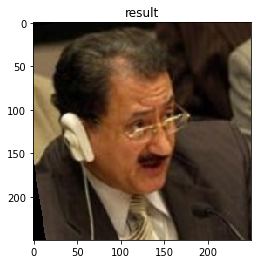

19

In [64]:
jupiter_utils.print_image(wrong_images[0])
len (wrong_paths)

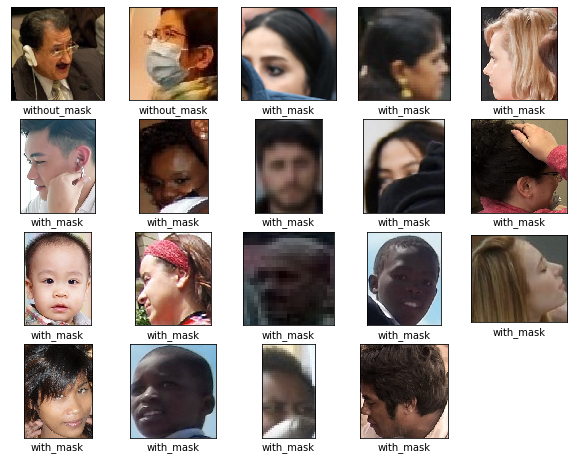

In [69]:
fig = plt.figure(figsize=(10,10))
# grid = ImageGrid(fig, 111, nrows_ncols=(4, 5), axes_pad=0.1)

class_names = ['with_mask', 'without_mask']

for i, image in enumerate(wrong_images):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.imshow(image, interpolation='none')
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[predictions[wrong_indexes[i]]])
plt.show()

In [85]:
[predictions[index] for index in wrong_indexes]

[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [86]:
all_data[wrong_indexes[0]]

'C:\\DevEnv\\Workspaces\\facemask-maker\\datasets\\ds5_fake_face_mask\\with_mask\\Abdul_Majeed_Shobokshi_0001.jpg'

In [84]:
path = all_data[3]
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))
img = img_to_array(img)
img = preprocess_input(img)
img_pred = mobile_model.model.predict(np.array([img], dtype='float32'))
print(np.argmax(img_pred, axis=1))

[0]


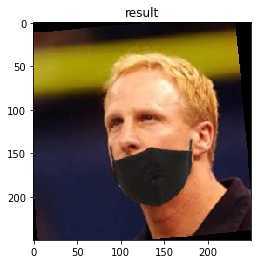

In [80]:
jupiter_utils.print_image(cv2.imread(all_data[3], cv2.COLOR_BGRA2RGB))